In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# FIX ME: Root dir as argument
root_dir = "../../data/picklerCheckpoints/"
is_compressed = True;

In [2]:
import nbimporter
import Preprocessing.SpatialMapping as sm
import Preprocessing.Discretization as dis
import time
import math
import seaborn as sns

Importing Jupyter notebook from D:\Academics\MLRepoNew\ML2020-Uber-Data-Analysis\Preprocessing\SpatialMapping.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoNew\ML2020-Uber-Data-Analysis\commons\utility\pickle_util.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoNew\ML2020-Uber-Data-Analysis\Preprocessing\DataEnrichment.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoNew\ML2020-Uber-Data-Analysis\Preprocessing\Discretization.ipynb


In [3]:
data = sm.run(['jun', 'jul'])

Data for the month :apr Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-apr14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-apr14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Data for the month :may Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-may14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-may14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [4]:
df = data.copy()
columns = ['datetime', 'zone', 'weatherCondition', 'humidity', 'pressure', 'temperature', 'windDirection', 'windSpeed', 'holiday']

In [5]:
df2 = df[columns]
df2g = dis.encode(df2, ['zone', 'weatherCondition', 'holiday'])
df2g = df2.groupby(columns).size().reset_index(name='counts')
df2g['datetime'] = pd.to_datetime(df2g['datetime'], format='%m-%d-%Y:%H').apply(lambda x: time.mktime(x.timetuple()))

D:\Academics\MLRepoNew\ML2020-Uber-Data-Analysis\Preprocessing\Discretization.ipynb:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "metadata": {},


Result Saved in ../data/encodedMappings/zone.p
Result Saved in ../data/encodedMappings/weatherCondition.p
Result Saved in ../data/encodedMappings/holiday.p


In [6]:
from sklearn.preprocessing import MinMaxScaler
counts = df2g['counts'].copy()
datetime = df2g['datetime'].copy()

In [7]:
df2g

,datetime,zone,weatherCondition,humidity,pressure,temperature,windDirection,windSpeed,holiday,counts
0,1.396291e+09,10,11,40.0,1016.0,282.96,330.0,5.0,1,3
1,1.396291e+09,11,11,40.0,1016.0,282.96,330.0,5.0,1,1
2,1.396291e+09,14,11,40.0,1016.0,282.96,330.0,5.0,1,2
3,1.396291e+09,22,11,40.0,1016.0,282.96,330.0,5.0,1,1
4,1.396291e+09,25,11,40.0,1016.0,282.96,330.0,5.0,1,1
...,...,...,...,...,...,...,...,...,...,...
175073,1.401557e+09,251,11,43.0,1023.0,292.80,30.0,5.0,2,3
175074,1.401557e+09,254,11,43.0,1023.0,292.80,30.0,5.0,2,5
175075,1.401557e+09,255,11,43.0,1023.0,292.80,30.0,5.0,2,8
175076,1.401557e+09,256,11,43.0,1023.0,292.80,30.0,5.0,2,11


In [8]:
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df2g) 
df2g.loc[:,:] = scaled_values
df2g['counts'] = counts
df2g['datetime'] = datetime

In [9]:
bins = [0, 10, 50, np.inf]
names = ['low', 'med', 'high']

df2g['label'] = pd.cut(df2g['counts'], bins, labels=names)

In [10]:
df2g = dis.encode(df2g, ['label'])

Result Saved in ../data/encodedMappings/label.p


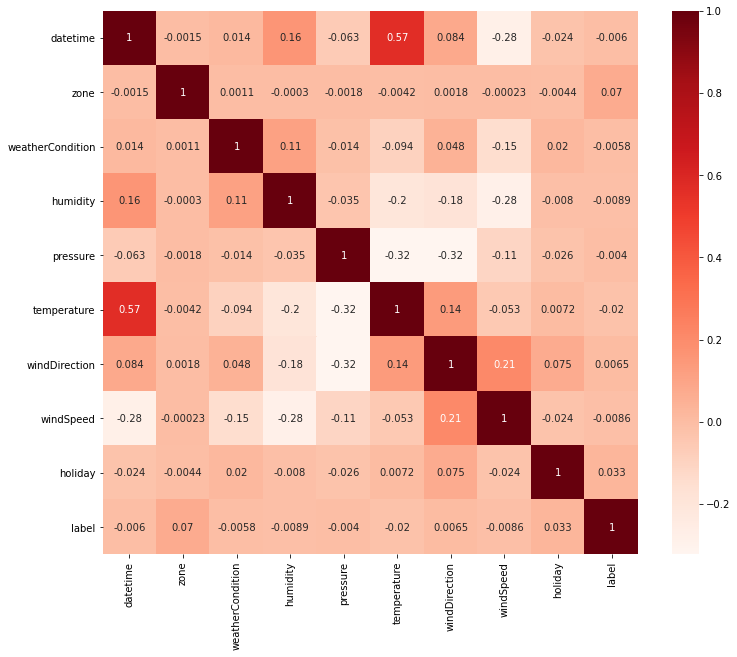

In [11]:
plt.figure(figsize=(12,10))
corrCols = columns.copy()
corrCols.append('label')
cor = df2g[corrCols].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [12]:
#Correlation with output variable
cor_target = abs(cor["label"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

label    1.0
Name: label, dtype: float64

In [13]:
class0, class1, class2 = df2g['label'].value_counts()

In [14]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=101)

In [15]:
x_ros, y_ros = ros.fit_resample(df2g[columns], df2g['label'])

In [16]:
class2

11133

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split( x_ros, y_ros, test_size=0.33, random_state=100)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [20]:
model = LinearRegression()
trained = model.fit(X_train, y_train)

In [21]:
x_predict = model.predict(X_test).astype(int)

In [22]:
# x_predictdf = pd.DataFrame(x_predict, columns =['counts'])
# x_predictdf['label'] = pd.cut(x_predictdf['counts'], bins, labels=names)
# x_predictdf = dis.encode(x_predictdf, ['label'])


In [23]:
# y_testdf = pd.DataFrame(y_test, columns =['counts'])
# y_testdf['label'] = pd.cut(y_testdf['counts'], bins, labels=names)
# y_testdf = dis.encode(y_testdf, ['label'])


In [24]:
X_test[y_test==2]

,datetime,zone,weatherCondition,humidity,pressure,temperature,windDirection,windSpeed,holiday
31500,1.396917e+09,0.684825,0.466667,0.922222,0.148936,0.279160,0.138889,0.166667,0.5
28892,1.397900e+09,0.322957,0.000000,0.211111,0.617021,0.514055,0.888889,0.333333,1.0
25125,1.396489e+09,0.373541,0.666667,0.922222,0.489362,0.206785,0.083333,0.166667,0.5
32078,1.400006e+09,0.291829,0.733333,0.722222,0.574468,0.532795,0.330556,0.250000,0.5
23579,1.401035e+09,0.536965,0.466667,0.200000,0.425532,0.864943,0.000000,0.250000,1.0
...,...,...,...,...,...,...,...,...,...
25166,1.400405e+09,0.525292,0.466667,0.488889,0.531915,0.564782,0.197222,0.166667,1.0
28166,1.399012e+09,0.322957,0.466667,0.866667,0.531915,0.459370,0.800000,0.083333,0.5
32149,1.400024e+09,0.525292,0.066667,0.711111,0.617021,0.386753,0.208333,0.166667,0.5
23735,1.398965e+09,0.607004,0.333333,0.911111,0.489362,0.549155,0.563889,0.166667,0.5


In [25]:
from sklearn import metrics

In [26]:
print(metrics.mean_absolute_error(y_test, x_predict))
print(metrics.mean_squared_error(y_test, x_predict))
print(metrics.r2_score(y_test, x_predict))

0.7514062783523862
1.0713119216113227
-0.5965519090769065


In [27]:
# print(metrics.mean_absolute_error(y_testdf['label'], x_predictdf['label']))
# print(metrics.mean_squared_error(y_testdf['label'], x_predictdf['label']))
# print(metrics.r2_score(y_testdf['label'], x_predictdf['label']))

In [28]:
from sklearn.metrics import classification_report

In [29]:
report = classification_report(y_test, x_predict)
print(report)

              precision    recall  f1-score   support

           0       0.42      0.67      0.52      3685
           1       0.39      0.56      0.46      3626
           2       0.00      0.00      0.00      3711

    accuracy                           0.41     11022
   macro avg       0.27      0.41      0.33     11022
weighted avg       0.27      0.41      0.33     11022



D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# report = classification_report(y_testdf['label'],  x_predictdf['label'])
# print(report)

In [31]:
from sklearn.decomposition import PCA

In [32]:
pca = PCA(n_components=2)

In [33]:
pca.fit(X_train)

PCA(n_components=2)

In [34]:
print(pca.explained_variance_ratio_)

[1.00000000e+00 4.90191442e-14]


In [35]:
print(pca.singular_values_)

[2.25305374e+08 4.98832124e+01]


In [36]:
transformed = pd.DataFrame(pca.fit_transform(X_train))


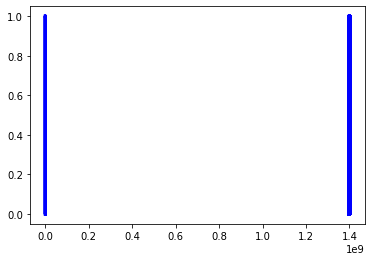

In [37]:
plt.plot(X_test, x_predict, color='blue', linewidth=3)

In [38]:
X_test

,datetime,zone,weatherCondition,humidity,pressure,temperature,windDirection,windSpeed,holiday
31500,1.396917e+09,0.684825,0.466667,0.922222,0.148936,0.279160,0.138889,0.166667,0.5
18995,1.400888e+09,0.867704,0.533333,0.944444,0.297872,0.503716,0.980556,0.083333,1.0
14545,1.400384e+09,0.824903,0.800000,0.766667,0.489362,0.338611,0.838889,0.000000,1.0
28892,1.397900e+09,0.322957,0.000000,0.211111,0.617021,0.514055,0.888889,0.333333,1.0
19264,1.396370e+09,0.295720,0.466667,0.400000,0.425532,0.462036,0.444444,0.333333,0.5
...,...,...,...,...,...,...,...,...,...
32149,1.400024e+09,0.525292,0.066667,0.711111,0.617021,0.386753,0.208333,0.166667,0.5
23735,1.398965e+09,0.607004,0.333333,0.911111,0.489362,0.549155,0.563889,0.166667,0.5
27396,1.399736e+09,0.529183,0.600000,0.600000,0.297872,0.758320,0.858333,0.083333,1.0
1097,1.396870e+09,0.591440,0.666667,0.477778,0.531915,0.357674,0.361111,0.333333,0.5


In [39]:
len(x_predict)

11022

No handles with labels found to put in legend.


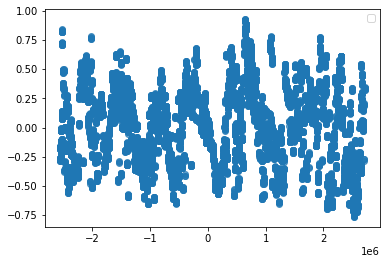

In [40]:
plt.scatter(transformed[0], transformed[1], alpha=0.7)
plt.legend()
plt.show()

In [41]:
X_train

,datetime,zone,weatherCondition,humidity,pressure,temperature,windDirection,windSpeed,holiday
1080,1.396867e+09,0.871595,0.666667,0.288889,0.553191,0.331179,0.277778,0.250000,0.5
6269,1.399477e+09,0.249027,0.000000,0.222222,0.531915,0.636511,0.605556,0.166667,0.5
27732,1.396370e+09,0.992218,0.466667,0.400000,0.425532,0.462036,0.444444,0.333333,0.5
15013,1.399459e+09,0.031128,0.800000,0.288889,0.574468,0.592569,0.819444,0.083333,0.5
31218,1.398515e+09,0.564202,0.733333,0.244444,0.212766,0.617124,0.916667,0.333333,1.0
...,...,...,...,...,...,...,...,...,...
16734,1.397637e+09,0.097276,0.466667,0.411111,0.659574,0.090145,0.916667,0.666667,0.5
16304,1.397295e+09,0.988327,0.733333,0.288889,0.595745,0.581583,0.000000,0.000000,1.0
79,1.396355e+09,0.871595,0.466667,0.277778,0.468085,0.464297,0.000000,0.083333,0.5
12119,1.398908e+09,0.649805,0.333333,0.922222,0.617021,0.470210,0.480556,0.333333,0.5
